# 1. Latent Dirichlet Allocation

We analyse the reviews written in Yelp for the restaurant 'ABC Kitchen' using LDA in an effort to do topic modeling. In other words, we use LDA to extract most common topics across the reviews. Doing so will help us in determining how the patrons are either liking or disliking the restaurant. 

## 1.1 Install required packages


In [ ]:
!pip install gensim==3.8.3 # install gensim for LDA

In [ ]:
!pip install nltk # install nltk to preprocess sentences

In [ ]:
!pip install pyldavis==3.2.2 # to visualize LDA topics

In [ ]:
!pip install matplotlib # for plotting

The cell below tests if the packages we need have been installed correctly, and that we are in the correct environment.

In [ ]:
import gensim
import nltk
nltk.download("stopwords")
import pyLDAvis
import matplotlib
import string
import re
import pandas as pd
%matplotlib inline

## 1.1 Read the data

Download review file into a pandas dataframe. Split the reviews by merchant name. There are 5 merchants in all; store one in each dataframe. 

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
path = "/content/gdrive/My Drive/LDA Yelp Review/"  #change the path to file location
filename = "yelp_review_ibm_label.csv" #filename
review_df = pd.read_csv(path+filename) #read into dataframe
review_df.head()

,Merhcant Name,Sentiment,Review,Date/Time,Rating,URL
0,ABC Kitchen,Positive,"I'm glad indoor dining has resumed in NYC, and...",2/17/21 7:54,5,https://www.yelp.com/biz/abc-kitchen-new-york?...
1,ABC Kitchen,Negative,A colleague of mine who is also a pretty loyal...,2/16/21 10:28,1,https://www.yelp.com/biz/abc-kitchen-new-york?...
2,ABC Kitchen,Positive,I had heard that they were doing outdoor dinin...,1/23/21 15:46,5,https://www.yelp.com/biz/abc-kitchen-new-york?...
3,ABC Kitchen,Positive,Outdoor dining in the winter can be challengin...,1/11/21 12:13,4,https://www.yelp.com/biz/abc-kitchen-new-york?...
4,ABC Kitchen,Positive,I ate inside when we were still able too but y...,1/7/21 19:51,5,https://www.yelp.com/biz/abc-kitchen-new-york?...


In [8]:
numMerchants = len(review_df['Merhcant Name'].unique())
merchants = review_df['Merhcant Name'].unique()

print("There are %d unqiue merchants. They are as follows: " %numMerchants)

for index, merchant in enumerate(merchants):
  print('Index: %d ; Merchant Name: %s' %(index, merchant))

There are 5 unqiue merchants. They are as follows: 
Index: 0 ; Merchant Name: ABC Kitchen
Index: 1 ; Merchant Name: ChikaLicious Dessert Bar
Index: 2 ; Merchant Name: MUD
Index: 3 ; Merchant Name: Soba-ya
Index: 4 ; Merchant Name: Gramercy Tavern


In [9]:
review_df_list = []

for merchant in merchants:
  temp_df = review_df.loc[review_df['Merhcant Name'] == merchant]
  review_df_list.append(temp_df)

## 1.2 Clean the data

The following sections are specific to only one merchant. Read output of next cell to find merchant name under evaluation.  

In [10]:
merchIndex = 0
print("Merchant Name under evaluation: %s" %(merchants[merchIndex])) 
temp_df = review_df_list[merchIndex] #temp_df will be used as data source going forward

Merchant Name under evaluation: ABC Kitchen


In [11]:
import re # to replace punctuations
from nltk.corpus import stopwords # list of stopwords

We will now read the data and preprocess it using the following steps:

   1. Remove stopwords
   2. Lower-case all words
   3. Remove words with less than 2 characters
   4. Remove punctuation
   5. Split each sentence into a list of words

In [13]:
# A function to clean a single line of text
def clean_line(line):
    """ Clean stopwords and punction for each line
    
    Args: 
        line (string): one line in file
        
    Returns:
        list(str): a list of all words in the sentence
    """
    
    stops = stopwords.words('english')
    stops.append("for")
    #print(stops)

    line = line.split(" ")
    filtered_content = []
    for word in line:
        #lower case words
        word_lower = str(word).lower()
                   
        #remove punctuation; same as keeping only alpha numeric
        non_alhpanum = re.compile(r'[\W]')  #matches any non-alpha num same as [^a-zA-Z0-9_]
        word_lower = non_alhpanum.sub(r'', word_lower)  #remove non alpha-num 
        
        #remove stop words
        if word_lower in stops:
            continue
        
        #remove words with less than two characters
        if len(word_lower) <= 2:
            continue     
                
        filtered_content.append(word_lower)
       
        
    return filtered_content

Finally, we put these two functions together to read and clean the dataset.

In [14]:
def read_dataset(dfname):
    """ Read the review column of the dataframe into list and clean stop words. 
        
    Args: 
        dfname (string): source data frame name
        
    Returns:
        list of list of words: we view each document as a list, including a list of all words 
    """
    count = 0
    exp_dataset = []
    for line in dfname['Review']:
        new_line = clean_line(line)
        exp_dataset.append(new_line)

    return exp_dataset

Call this function to obtain the data in the cell below.

In [15]:
%%time
r = read_dataset(temp_df)

CPU times: user 212 ms, sys: 6.48 ms, total: 219 ms
Wall time: 388 ms


## 1.3 Topic analysis using LDA

We will now use `gensim` to train an LDA model. `gensim` requires the following steps:

   1. Construct a `gensim.corpora.dictionary` from the dataset
   2. Construct a `gensim` "corpus" using this dictionary, by mapping each word to an index in the dictionary
   3. Run LDA on this corpus

In [16]:
import gensim
import gensim.corpora as corpora

In [17]:
dictionary = corpora.Dictionary(r) # create a gensim dictionary, store it in variable "dictionary"

# create the gensim corpus, store it in variable "corpus"
texts = r 
# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in texts]

In [18]:
print("There are %d distinct words in the document" %(len(corpus)))

There are 200 distinct words in the document


The function below prints the top `num` words in each topic for a given model.

In [19]:
def print_topic_words(model,num):
    """ print top words in model topics.
    
    Args: 
        model: LDA model
        
    Returns:
        none
    """    

    print(model.print_topics(num_words = num))
        
    return

The following function builds multiple LDA models with number of topics specified in the list `num_topics`.

In [20]:
def build_num_topic_model(dictionary, corpus, num_topics):
    """ Build lda model with given parameters, use print_topic_words to print words
    
    Args: 
        dictionary: dictionary built from dataset
        corpus: corpus built from dataset
        num_topics: list of numbers
        
    Returns:
        none
    """    
    for num_topic in num_topics:

        
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topic, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)
        
        print("No. of topics: %s" %(num_topic))
        for topic_num in range(num_topic):
            print('\tTopic Number: %s' %(topic_num))
            print("\t\t" + str(lda_model.print_topic(topic_num, topn = 5).split(' + ')))
            #print_topic_words(lda_model,5)
        print('\n-------------\n')

In [21]:
build_num_topic_model(dictionary, corpus, [3, 6, 9, 12, 15])

No. of topics: 3
	Topic Number: 0
		['0.014*"good"', '0.011*"food"', '0.010*"great"', '0.008*"service"', '0.007*"delicious"']
	Topic Number: 1
		['0.010*"restaurant"', '0.010*"abc"', '0.009*"food"', '0.008*"good"', '0.007*"table"']
	Topic Number: 2
		['0.007*"pizza"', '0.007*"restaurant"', '0.005*"great"', '0.005*"one"', '0.005*"place"']

-------------

No. of topics: 6
	Topic Number: 0
		['0.022*"good"', '0.017*"food"', '0.011*"would"', '0.010*"amazing"', '0.010*"service"']
	Topic Number: 1
		['0.014*"restaurant"', '0.012*"food"', '0.010*"table"', '0.009*"like"', '0.008*"service"']
	Topic Number: 2
		['0.007*"food"', '0.007*"great"', '0.007*"would"', '0.006*"texture"', '0.006*"good"']
	Topic Number: 3
		['0.007*"love"', '0.006*"reservation"', '0.006*"chocolate"', '0.006*"delicious"', '0.005*"pizza"']
	Topic Number: 4
		['0.012*"good"', '0.011*"great"', '0.009*"abc"', '0.009*"delicious"', '0.008*"toast"']
	Topic Number: 5
		['0.009*"place"', '0.007*"scrambled"', '0.007*"couple"', '0.00

Each topic in models with number of topics as 3 and 6 seems to be overlapping with one another. Models with number of topics as 12 or higher seem to have too many topics to make sense. 

We choose nine as the optimal number of topics, because nine topics seem to capture the different themes (including negative opinions) appropriately without being too similar to one another. Additionally, for 8 out of the 9 topics, their top 5 words are able to explain each reasonably well.  

##  1.4 Topic Model Evaluation with quantitative metrics - coherence and perplexitiy

We have seen how to visually evaluate a topic model by looking at the top-words in each topic. Now we take a more quantitative view, and quantify the usefulness of each topic model as measured by its (1) "coherence" (to what extent is the topic focused on a single, narrow theme), and (2) "perplexity", which is the likelihood of the observed data under the given model, or how surprised the model is when looking at the words of a test set.

In [22]:
from gensim.models.coherencemodel import CoherenceModel

The code below trains topic models with different numbers of topics and measures their coherence and perplexity.

In [23]:
# perplexity 
# run different number of topics to get perplexity and coherence value for this model
def get_measurement_for_model(dictionary, corpus, topic_nums):
    """ Build lda model with given parameters 
    
    Args: 
        dictionary: dictionary built from dataset
        corpus: corpus built from dataset
        topic_nums: a list contains all possible topic number
        
    Returns:
        2 lists: one of perplexities, and one of coherence value
    """  
    perplexity = []
    coherence_value=[]
    for num_topic in topic_nums:
        #########################
        # YOUR CODE HERE
        #   - Build model
        #   - Compute and store coherence
        #   - Compute and store perplexity
        #########################
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topic, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)
        
        perplexity.append(lda_model.log_perplexity(corpus))
        
        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        
        coherence_value.append(coherence_lda)     
        
    return perplexity,coherence_value

In [24]:
perplexity, coherence = get_measurement_for_model(dictionary, corpus, [3, 6, 9, 12, 15, 20, 50])

We can now plot the coherence and perplexity of each model.

In [25]:
import matplotlib.pyplot as plt

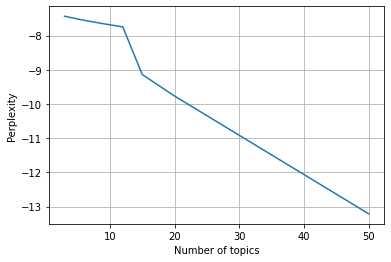

In [26]:
plt.plot([3, 6, 9, 12, 15, 20, 50], perplexity)
plt.grid()
plt.xlabel("Number of topics")
plt.ylabel("Perplexity")
plt.show()

It is clear from the above graph that the perplexity goes down as the number of topics increases. It suggests that having a higher number of topics is better, however as we have seen during our heuristic analysis, going beyond 9 topics may not yield better results. In fact we do see a slight downward bend near topic 9, so we may be safe in going with 9 as our optimal number of topics. 

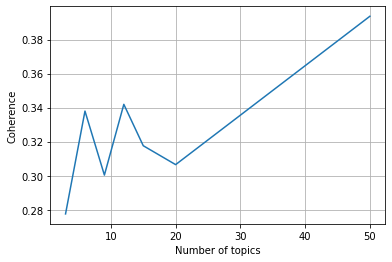

In [27]:
plt.plot([3, 6, 9, 12, 15, 20, 50], coherence)
plt.grid()
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.show()

Based on the plot above, the coherence score peaks at around topics 3 and 12. However, as we have seen during our heuristic analysis that neither of these topic numbers is ideal. In fact, we see that the coherence score at our chosen topic number of 9 is at 0.30, which is not too less than that for topic number 12 at 0.34 . So, that gives us confidence in pursuing 9 topics. 

Picking the optimal number of topics based on low perplexity score may not produce human-interpretable topics. On the other hand, the coherence score, which measures the semantic similarity between high scoring words in the topic, is a better measure of the topics’ interpretation. This hypothesis is further validated in the present example, where we see that even as the perplexity plunges with increase in topics, the coherence score, although increasing slightly, never goes out of control with more topics.

## 1.5 Choose best Alpha and Beta in LDA model 

We will check the two most important parameters in LDA model: alpha and beta. Alpha represents document-topic density - with a higher alpha, documents are made up of more topics, and with lower alpha, documents contain fewer topics. Beta represents topic-word density - with a high beta, topics are made up of most of the words in the corpus, and with a low beta they consist of few words.

In [28]:
best_topic_num = 9 # CHANGE THIS

In [29]:
#model 1

#########################
#   - Build model for alpha = 1/num_topic = eta
#   - Print top words
#########################

model1 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=best_topic_num, 
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha=[1/best_topic_num]*best_topic_num,
                                   eta = 1/best_topic_num, 
                                   per_word_topics=False)

for topic_num in range(best_topic_num):
    print('Topic Number: %s' %(topic_num))
    print("\t" + str(model1.print_topic(topic_num, topn = 10).split(' + ')))

Topic Number: 0
	['0.025*"food"', '0.019*"amazing"', '0.018*"good"', '0.011*"service"', '0.008*"restaurant"', '0.007*"tuna"', '0.007*"sashimi"', '0.006*"menu"', '0.006*"ordered"', '0.006*"dark"']
Topic Number: 1
	['0.017*"restaurant"', '0.015*"table"', '0.013*"food"', '0.009*"service"', '0.009*"good"', '0.008*"check"', '0.008*"time"', '0.008*"like"', '0.007*"minutes"', '0.007*"order"']
Topic Number: 2
	['0.008*"much"', '0.008*"slamming"', '0.006*"one"', '0.006*"even"', '0.006*"hate"', '0.006*"pita"', '0.005*"think"', '0.005*"kinda"', '0.005*"suggestions"', '0.005*"tip"']
Topic Number: 3
	['0.009*"chocolate"', '0.008*"presentation"', '0.008*"pizza"', '0.006*"complete"', '0.006*"strawberry"', '0.005*"delicious"', '0.005*"restaurant"', '0.005*"reservation"', '0.005*"pesto"', '0.005*"got"']
Topic Number: 4
	['0.015*"good"', '0.013*"great"', '0.011*"food"', '0.009*"salad"', '0.009*"abc"', '0.009*"delicious"', '0.009*"ordered"', '0.008*"service"', '0.008*"restaurant"', '0.007*"pizza"']
Topic

In [30]:
#model 2

#########################
#   - Build model for alpha = 1/2, eta = 1/5
#   - Print top words
#########################

model2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=best_topic_num, 
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha=[1/2]*best_topic_num,
                                   eta = 1/5, 
                                   per_word_topics=False)

for topic_num in range(best_topic_num):
    print('Topic Number: %s' %(topic_num))
    print("\t" + str(model2.print_topic(topic_num, topn = 10).split(' + ')))

Topic Number: 0
	['0.020*"food"', '0.020*"good"', '0.014*"amazing"', '0.007*"service"', '0.007*"sashimi"', '0.006*"tuna"', '0.006*"restaurant"', '0.004*"definitely"', '0.004*"saturday"', '0.004*"come"']
Topic Number: 1
	['0.014*"restaurant"', '0.012*"food"', '0.011*"table"', '0.007*"time"', '0.007*"service"', '0.007*"back"', '0.007*"good"', '0.007*"like"', '0.007*"check"', '0.006*"dining"']
Topic Number: 2
	['0.005*"slamming"', '0.003*"much"', '0.003*"even"', '0.003*"one"', '0.003*"hostess"', '0.002*"second"', '0.002*"make"', '0.002*"need"', '0.002*"couldnt"', '0.002*"think"']
Topic Number: 3
	['0.008*"chocolate"', '0.007*"pizza"', '0.004*"restaurant"', '0.004*"herbs"', '0.004*"moment"', '0.004*"pesto"', '0.003*"nice"', '0.003*"brussel"', '0.003*"crust"', '0.003*"goat"']
Topic Number: 4
	['0.012*"good"', '0.010*"great"', '0.010*"abc"', '0.009*"food"', '0.009*"delicious"', '0.008*"salad"', '0.008*"restaurant"', '0.007*"service"', '0.007*"kitchen"', '0.007*"pizza"']
Topic Number: 5
	['0.

In [31]:
#model 3
 
#########################
#   - Build model for alpha = 'auto' = eta
#   - Print top words
#########################

model3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=best_topic_num, 
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha='auto',
                                   eta = 'auto', 
                                   per_word_topics=False)

for topic_num in range(best_topic_num):
    print('Topic Number: %s' %(topic_num))
    print("\t" + str(model3.print_topic(topic_num, topn = 10).split(' + ')))

Topic Number: 0
	['0.026*"food"', '0.019*"amazing"', '0.018*"good"', '0.011*"service"', '0.008*"restaurant"', '0.007*"tuna"', '0.007*"sashimi"', '0.006*"menu"', '0.006*"ordered"', '0.006*"dark"']
Topic Number: 1
	['0.017*"restaurant"', '0.016*"table"', '0.013*"food"', '0.009*"service"', '0.008*"good"', '0.008*"time"', '0.008*"check"', '0.008*"minutes"', '0.007*"like"', '0.007*"order"']
Topic Number: 2
	['0.009*"much"', '0.008*"slamming"', '0.006*"one"', '0.006*"pita"', '0.006*"hate"', '0.005*"even"', '0.005*"kinda"', '0.005*"suggestions"', '0.005*"tip"', '0.004*"think"']
Topic Number: 3
	['0.009*"chocolate"', '0.008*"presentation"', '0.008*"pizza"', '0.006*"complete"', '0.006*"strawberry"', '0.005*"delicious"', '0.005*"restaurant"', '0.005*"pesto"', '0.005*"reservation"', '0.005*"make"']
Topic Number: 4
	['0.014*"good"', '0.013*"great"', '0.012*"food"', '0.009*"salad"', '0.009*"abc"', '0.008*"ordered"', '0.008*"delicious"', '0.008*"service"', '0.008*"restaurant"', '0.007*"pizza"']
Topi

As we increase beta from 0.11 (model 1) to 0.2 (model 2), the interpretability of the topics goes down. With a beta value of 0.2, we are not able to see the negative topics. However, we get best results when we set the beta value to ‘auto’, which allows the model to learn the a-priori belief from the data. Each topic is easily interpretable and distinct from one another. 

## 1.7 LDA visualization and Final Conclusions

We will now visualize the LDA output using pyLDAvis. PyLDAVis shows the following:

   1. The distances between topics, as a map in 2-D space.
   2. The variance in the topic-word distribution, as the size of a circle in this map.
   3. The most "relevant" terms in each topic.
   4. The overall "salient" terms in the document.

In [33]:
%%time
import pyLDAvis.gensim
import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

CPU times: user 10.5 ms, sys: 1.98 ms, total: 12.5 ms
Wall time: 12.9 ms


In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
#train gensim LDA model with best_topic_num topics
model_viz = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=best_topic_num, 
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha='auto',
                                   eta = 'auto', 
                                   per_word_topics=False)

for topic_num in range(best_topic_num):
    print('Topic Number: %s' %(topic_num+1))
    print("\t" + str(model_viz.print_topic(topic_num, topn = 10).split(' + ')))

Topic Number: 1
	['0.026*"food"', '0.019*"amazing"', '0.018*"good"', '0.011*"service"', '0.008*"restaurant"', '0.007*"tuna"', '0.007*"sashimi"', '0.006*"menu"', '0.006*"ordered"', '0.006*"dark"']
Topic Number: 2
	['0.017*"restaurant"', '0.016*"table"', '0.013*"food"', '0.009*"service"', '0.008*"good"', '0.008*"time"', '0.008*"check"', '0.008*"minutes"', '0.007*"like"', '0.007*"order"']
Topic Number: 3
	['0.009*"much"', '0.008*"slamming"', '0.006*"one"', '0.006*"pita"', '0.006*"hate"', '0.005*"even"', '0.005*"kinda"', '0.005*"suggestions"', '0.005*"tip"', '0.004*"think"']
Topic Number: 4
	['0.009*"chocolate"', '0.008*"presentation"', '0.008*"pizza"', '0.006*"complete"', '0.006*"strawberry"', '0.005*"delicious"', '0.005*"restaurant"', '0.005*"pesto"', '0.005*"reservation"', '0.005*"make"']
Topic Number: 5
	['0.014*"good"', '0.013*"great"', '0.012*"food"', '0.009*"salad"', '0.009*"abc"', '0.008*"ordered"', '0.008*"delicious"', '0.008*"service"', '0.008*"restaurant"', '0.007*"pizza"']
Topi

In [36]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(model_viz, corpus, dictionary, mds="tsne", sort_topics=False)
LDAvis_prepared

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      111.092506 -133.722946       1        1   5.905181
1       34.946613  107.064590       2        1  11.721977
2      -28.088213 -159.949036       3        1   1.187840
3      147.698074   21.369604       4        1   3.767991
4      -97.501183  126.981384       5        1  26.770985
5       30.312096  -32.794945       6        1   1.167275
6     -155.443665 -118.494690       7        1  36.516446
7     -204.248108   22.596130       8        1   5.609725
8      -79.404678   -6.864717       9        1   7.352580, topic_info=           Term        Freq       Total Category  logprob  loglift
13         food  103.000000  103.000000  Default  30.0000  30.0000
171        good  125.000000  125.000000  Default  29.0000  29.0000
191     amazing   34.000000   34.000000  Default  28.0000  28.0000
31      service   71.000000   71.000000  Default  27.0000  27.0000
28   restaurant   93.000000   93.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
500       could    3.892729   25.427525   Topic9  -5.3824   0.7334
395      salmon    3.951951   31.162681   Topic9  -5.3673   0.5451
4          come    3.823879   22.194386   Topic9  -5.4002   0.8515
159       toast    3.971496   51.478611   Topic9  -5.3623   0.0481
18         like    3.988529   61.976599   Topic9  -5.3580  -0.1332

[592 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
218       6  0.704531    128
872       1  0.491054    915
118       1  0.043644    abc
118       2  0.058192    abc
118       4  0.014548    abc
...     ...       ...    ...
37        8  0.013731  would
37        9  0.013731  would
2387      8  0.979654   year
1040      7  0.791871  yummy
2056      9  0.829322   zero

[917 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9])

Topic Interpretation in decreasing order of importance (most prevalent topic appears at the top):

**Topic #7**: Overwhelmingly positive reviews, mostly focussed on ‘delicious’ and ‘flavorful’ dishes. Some of the popular food items include chicken, crab, cake, and sauce. Patrons also liked the ‘decor’ of the restaurant. 

**Topic #5**: Positive food reviews like Topic #7, but focused on a separate set of food items such as salad, pizza, squash, mushroom, salmon, sea-food/fish, kale  and burger. Interestingly, patrons seems to give out high Net Promoter Score (NPS), as they ‘recommend-ed’ this place.

**Topic #2**: Poor reviews, as ‘management’ may have had to ‘apologize’ for ‘mistake(s)’ , extended ‘wait’, and ‘poor’ / ‘rushed’ service. 

**Topic #9**: Average reviews, as patrons felt ‘short’ on their ‘expectations’. Food may have been ‘burnt’, ‘nonetheless’ they may have liked the ‘ambience’ in general. 

**Topic #1**: Positive reviews, focussed on ‘good service’ and good sea-food such as ‘tuna’, ‘sashimi’.  

**Topic #8**: Neutral reviews made by patrons visiting on ’Saturday brunches’ . Food items such as ‘scrambled eggs’, ‘pancakes’ , ‘buttermilk’, ‘biscuits’ are discussed with a neutral tone with words like ‘exquisite’ and ‘however’ thrown together.

**Topic #4**: Overwhelmingly Positive reviews, as patrons came with families (‘daughter’) and liked ‘presentation’ and ‘combination’ of the food items, going as far as calling out ‘worthy’ of ‘Michelin’. Interestingly patrons appreciated produces such as ’strawberries’, and ’brussels sprouts’,  indicating the restaurant may be using good quality fresh produces. 

**Topics #3 and #6**: Poor reviews as patrons complained about service (‘hostess’, ‘server’). 

**Conclusion**: Overall, the business has received mostly positive reviews around food, decor, and ambience. The poor reviews constitute less of the overall reviews and are mostly around the poor service quality. 